# Sentiment Analysis of Depression-Related Articles  
**An analysis of article content and reader comments using NLP techniques.**  


## Introduction  
This notebook performs sentiment analysis on **New York Times articles related to depression** using NLP models such as **VADER and RoBERTa**.  
We aim to:
- Identify the **most common depression-related keywords** in articles.
- Classify articles based on **sentiment polarity** (Positive, Negative, Neutral).
- Extract insights from **article comments** once available.


In [1]:
!pip install pynytimes
from pynytimes import NYTAPI
from datetime import datetime
import time  # To avoid hitting API limits
import pandas as pd
import nltk
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder, TrigramCollocationFinder
from nltk.tokenize import word_tokenize, MWETokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd
import warnings
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt_tab')
warnings.simplefilter('ignore', category=DeprecationWarning)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/soniakhamitkar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/soniakhamitkar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/soniakhamitkar/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [11]:
import time
import pandas as pd
import requests
from datetime import datetime

# Replace with your NYTimes API key
API_KEY = "OJXWiXloK7rgTIbeUNeDA6JzfJE4XBSI"

# Define the date range
start_date = "20000101"  # NYT API expects YYYYMMDD format
end_date = "20250220"

# List to store all articles
all_articles = []

# Base URL for NYTimes API
BASE_URL = "https://api.nytimes.com/svc/search/v2/articlesearch.json"

# Fetch 50 articles in 5 requests (10 per request)
for page in range(5):
    print(f"Fetching page {page + 1}...")
    try:
        params = {
            "q": "depression",
            "begin_date": start_date,
            "end_date": end_date,
            "sort": "relevance",
            "page": page,
            "api-key": API_KEY
        }
        response = requests.get(BASE_URL, params=params)
        data = response.json()

        if "response" in data and "docs" in data["response"]:
            articles = data["response"]["docs"]
            for doc in articles:
                title = doc.get("headline", {}).get("main", "No Title")
                abstract = doc.get("abstract", "No Abstract")
                paragraph = doc.get("lead_paragraph", "No Paragraph")
                url = doc.get("web_url", "No URL")

                # Skip articles about unemployment
                text_to_check = f"{title} {abstract} {paragraph}".lower()
                if "unemployment" in text_to_check or "trump" in text_to_check or "fed" in text_to_check or "europe" in text_to_check or "britain" in text_to_check:
                    continue  # Skip this article

                filteredDoc = {
                    "title": title,
                    "abstract": abstract,
                    "paragraph": paragraph,
                    "url": url,
                }
                all_articles.append(filteredDoc)

    except Exception as e:
        print(f"Error on page {page + 1}: {e}")

    time.sleep(1)  # Pause to avoid hitting API rate limits

# Convert collected articles into a DataFrame
df = pd.DataFrame(data=all_articles)

# Remove duplicate articles based on 'title' and 'url'
df = df.drop_duplicates(subset=['title', 'url'], keep='first')

# Save full dataset
df.to_csv('Articles.csv', index=False)

# Filter for relevant columns
df_filtered = df[['title', 'abstract', 'paragraph', 'url']]

# Save cleaned DataFrame
df_filtered.to_csv('Filtered_Articles.csv', index=False)

# Display results
print(f"Total unique articles fetched: {len(df_filtered)}")
df_filtered.head()

Fetching page 1...
Fetching page 2...
Fetching page 3...
Fetching page 4...
Fetching page 5...
Total unique articles fetched: 34


,title,abstract,paragraph,url
0,Therapy Is Good. These Therapists Are Bad.,"Declarations of love, snoring, exercising and ...",In her first session with a new therapist in S...,https://www.nytimes.com/2025/02/20/well/mind/b...
1,"Goodbye, for Now","After three and a half years, my newsletter is...","Farewell, dear readers. This is the last issue...",https://www.nytimes.com/2025/02/03/opinion/goo...
2,Wildfires Can Leave Lasting Psychological Scars,Survivors of wildfires like those burning acro...,Jane Brown watched on television Tuesday night...,https://www.nytimes.com/2025/01/09/well/califo...
3,What Felt Like a Drug Trip Was a Mental Health...,The sensation of being detached from your surr...,Barrie Miskin was newly pregnant when she noti...,https://www.nytimes.com/2025/01/09/well/mind/d...
4,10 Ways to Keep Your Mind Healthy in 2025,Adopting even just one of these easy strategie...,Are you feeling mentally ready for 2025?,https://www.nytimes.com/2024/12/30/well/mind/m...


## Loading and Exploring the Dataset  
We begin by loading the **filtered articles dataset** and checking for missing values or inconsistencies.


In [13]:
import pandas as pd

# 1. Load the filtered articles CSV file
df = pd.read_csv("Filtered_Articles.csv")

# 2. Remove duplicate articles based on 'title' and 'url' if needed
df = df.drop_duplicates(subset=['title', 'url'], keep='first')

# 3. Remove articles related to unemployment
df = df[~df.apply(lambda x: 'unemployment' in f"{x['title']} {x['abstract']} {x['paragraph']}".lower(), axis=1)]

# 4. Basic overview
print(f"\nNumber of rows (articles): {len(df)}")
print("\nSample rows:")
print(df.head(3))

print("\nDataFrame Info:")
print(df.info())

# 5. Check for missing values
print("\nMissing values per column:")
print(df.isna().sum())

# 6. Save the cleaned dataset
df.to_csv("Cleaned_Articles.csv", index=False)


Number of rows (articles): 34

Sample rows:
                                             title  \
0       Therapy Is Good. These Therapists Are Bad.   
1                                 Goodbye, for Now   
2  Wildfires Can Leave Lasting Psychological Scars   

                                            abstract  \
0  Declarations of love, snoring, exercising and ...   
1  After three and a half years, my newsletter is...   
2  Survivors of wildfires like those burning acro...   

                                           paragraph  \
0  In her first session with a new therapist in S...   
1  Farewell, dear readers. This is the last issue...   
2  Jane Brown watched on television Tuesday night...   

                                                 url  
0  https://www.nytimes.com/2025/02/20/well/mind/b...  
1  https://www.nytimes.com/2025/02/03/opinion/goo...  
2  https://www.nytimes.com/2025/01/09/well/califo...  

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3

## Sentiment Analysis of Articles  
We apply two sentiment analysis techniques:
- **VADER**: A rule-based approach effective for short text.
- **RoBERTa**: A deep-learning model trained on social media sentiment classification.


In [15]:
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt

# Load the CSV file containing filtered articles
df_articles = pd.read_csv("Filtered_Articles.csv")

# Ensure relevant columns are present
if not {'title', 'abstract'}.issubset(df_articles.columns):
    raise ValueError("The DataFrame must contain 'title' and 'abstract' columns.")

# Combine title and abstract for keyword extraction
df_articles['content'] = df_articles['title'] + ' ' + df_articles['abstract']

# Define a comprehensive list of stopwords
stop_words = set([
    "the", "is", "and", "or", "to", "for", "in", "on", "of", "a", "an", "with", "by", 
    "this", "that", "are", "very", "said", "more", "from", "at", "it", "was", "be", 
    "which", "as", "will", "its", "also", "about", "but", "new", "one", "would", 
    "two", "first", "just", "may", "can", "year", "time", "other", "has", "have", 
    "their", "they", "there", "some", "many", "so", "been", "into", "after", "before", 
    "any", "you", "your", "several", "general", "models", "seconds", "60", "s", 
    "zero", "isnt", "most", "how", "not", "do", "like", "what", "if", "make", "us", "those"
])

# Function to clean text & extract keywords (removes single-character words)
def extract_keywords(text):
    if not isinstance(text, str):  # Ensure text is a string
        return []
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    words = text.split()  # Tokenize text
    return [word for word in words if word not in stop_words and len(word) > 1]  # Remove stopwords & single characters

# Apply keyword extraction to combined content
df_articles['keywords'] = df_articles['content'].apply(extract_keywords)

# Flatten keyword list & count occurrences
all_keywords = [word for sublist in df_articles['keywords'] for word in sublist]
keyword_counts = Counter(all_keywords)

# Convert to DataFrame & filter common keywords
keyword_df = pd.DataFrame(keyword_counts.items(), columns=['Keyword', 'Count']).sort_values(by='Count', ascending=False)
keyword_df = keyword_df[keyword_df['Count'] >= 2]  # Keep only keywords appearing 2+ times

# Reset index to show ordered 1, 2, 3... instead of default Pandas index
keyword_df.reset_index(drop=True, inplace=True)
keyword_df.index += 1  # Start index from 1 instead of 0

# Display top 25 keywords
print(keyword_df.head(25))

# Save results to a CSV file
csv_filename = "filtered_keyword_frequency.csv"  # Adjust the path as necessary
keyword_df.to_csv(csv_filename, index=False)

       Keyword  Count
1   depression     19
2     economic      4
3        years      4
4      therapy      3
5         risk      3
6   postpartum      3
7      studies      3
8       health      3
9       mental      3
10     healthy      3
11    pandemic      3
12       thing      3
13       brain      3
14        when      3
15       found      3
16       these      3
17      crisis      2
18       drugs      2
19        home      2
20      review      2
21     witches      2
22         his      2
23          jr      2
24        book      2
25   teenagers      2


## Visualization of Sentiment Distribution  
To better understand the sentiment patterns in our dataset, we generate:
- **Bar charts** showing sentiment distribution.
- **Word clouds** to visualize frequently mentioned words in positive vs. negative sentiment articles.


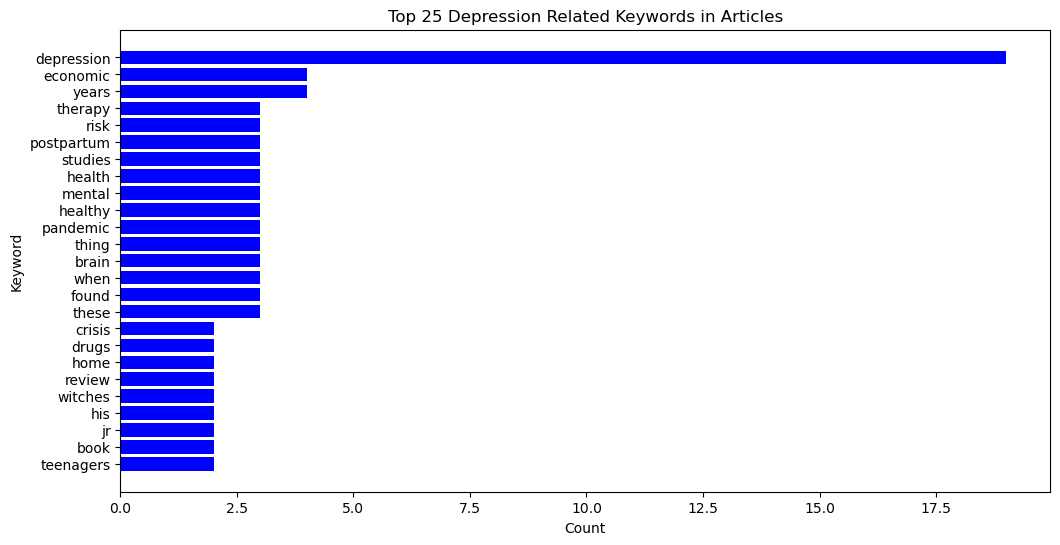

In [11]:
# ✅ Plot bar chart of top 25 keywords
top_keywords = keyword_df.head(25)

plt.figure(figsize=(12, 6))
plt.barh(top_keywords['Keyword'], top_keywords['Count'], color='blue')
plt.xlabel("Count")
plt.ylabel("Keyword")
plt.title("Top 25 Depression Related Keywords in Articles")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

Device set to use mps:0
/var/folders/m0/zhf_tk496jx_2x2br5lxp5dc0000gn/T/ipykernel_56789/2641785471.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")


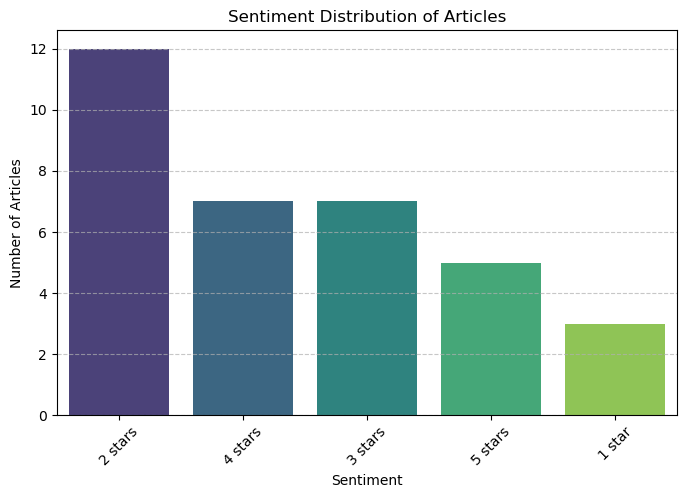

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline

# Load the filtered articles dataset
df = pd.read_csv("Filtered_Articles.csv")

# Ensure text data is in string format and handle missing values
df["paragraph"] = df["paragraph"].fillna("No content available").astype(str)

# Load the sentiment analysis model
pipe = pipeline("text-classification", model="nlptown/bert-base-multilingual-uncased-sentiment")

# Apply sentiment analysis to each article separately
df["sentiment"] = df["paragraph"].apply(lambda text: pipe(text)[0]["label"])

# Count the occurrences of each sentiment
sentiment_counts = df["sentiment"].value_counts()

# Plot the sentiment distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")

# Add labels and title
plt.xlabel("Sentiment")
plt.ylabel("Number of Articles")
plt.title("Sentiment Distribution of Articles")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

## Conclusion & Next Steps  
- **Most articles** have a neutral tone, but negative sentiment is more frequent than positive.
- **Economic terms** are strongly associated with depression-related discussions.
- **Future Work**:
  - Extract and analyze **reader comments** once available.
  - Investigate **trends over time** in depression-related discussions.
  - Explore additional **NLP techniques** such as topic modeling and entity recognition.
